# Run FlowSOM for pixel and cell clustering

In [1]:
import harpy as hp
from harpy.datasets import pixie_example
from harpy.utils._keys import ClusteringKey

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## 1. Load example dataset

In [2]:
sdata = pixie_example()
sdata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/cr

SpatialData object
├── Images
│     ├── 'raw_image_fov0': DataArray[cyx] (22, 512, 512)
│     ├── 'raw_image_fov1': DataArray[cyx] (22, 1024, 1024)
│     ├── 'raw_image_fov2': DataArray[cyx] (22, 1024, 1024)
│     ├── 'raw_image_fov3': DataArray[cyx] (22, 1024, 1024)
│     ├── 'raw_image_fov4': DataArray[cyx] (22, 1024, 1024)
│     ├── 'raw_image_fov5': DataArray[cyx] (22, 1024, 1024)
│     ├── 'raw_image_fov6': DataArray[cyx] (22, 1024, 1024)
│     ├── 'raw_image_fov7': DataArray[cyx] (22, 1024, 1024)
│     ├── 'raw_image_fov8': DataArray[cyx] (22, 1024, 1024)
│     ├── 'raw_image_fov9': DataArray[cyx] (22, 1024, 1024)
│     └── 'raw_image_fov10': DataArray[cyx] (22, 1024, 1024)
├── Labels
│     ├── 'label_nuclear_fov0': DataArray[yx] (512, 512)
│     ├── 'label_nuclear_fov1': DataArray[yx] (1024, 1024)
│     ├── 'label_nuclear_fov2': DataArray[yx] (1024, 1024)
│     ├── 'label_nuclear_fov3': DataArray[yx] (1024, 1024)
│     ├── 'label_nuclear_fov4': DataArray[yx] (1024, 1024)
│     ├

In [3]:
channels = [
    "CD3",
    "CD4",
    "CD8",
    "CD14",
    "CD20",
    "CD31",
    "CD45",
    "CD68",
    "CD163",
    "CK17",
    "Collagen1",
    "Fibronectin",
    "ECAD",
    "HLADR",
    "SMA",
    "Vim",
]

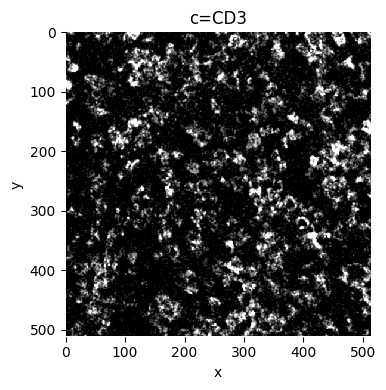

In [4]:
hp.pl.plot_image(sdata, img_layer="raw_image_fov0", to_coordinate_system="fov0", channel="CD3", figsize=(4, 4))

<Axes: title={'center': 'CD3'}, xlabel='Intensity', ylabel='Frequency'>

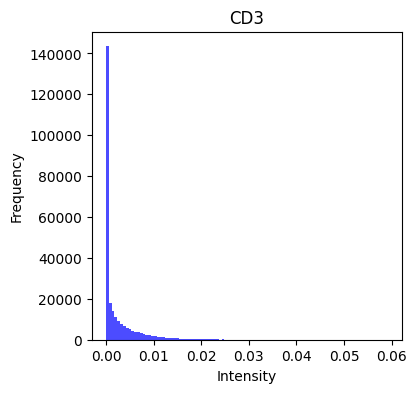

In [5]:
hp.pl.histogram(
    sdata,
    img_layer="raw_image_fov0",
    channel="CD3",
    bins=100,
    fig_kwargs={
        "figsize": (4, 4),
    },
)

## 2. Preprocess

In [6]:
sdata = hp.im.pixel_clustering_preprocess(
    sdata,
    img_layer=["raw_image_fov0", "raw_image_fov1"],
    output_layer=["raw_image_fov0_processed", "raw_image_fov1_processed"],
    channels=channels,
    chunks=2048,
    persist_intermediate=True,  # set to False if you have multiple images, and if they are large.
    overwrite=True,
    sigma=2.0,
)

2025-09-10 09:13:20,382 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov0_processed'
2025-09-10 09:13:20,387 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov1_processed'


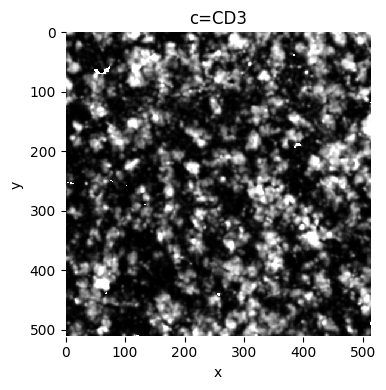

In [7]:
hp.pl.plot_image(
    sdata, img_layer="raw_image_fov0_processed", to_coordinate_system="fov0", channel="CD3", figsize=(4, 4)
)

<Axes: title={'center': 'CD3'}, xlabel='Intensity', ylabel='Frequency'>

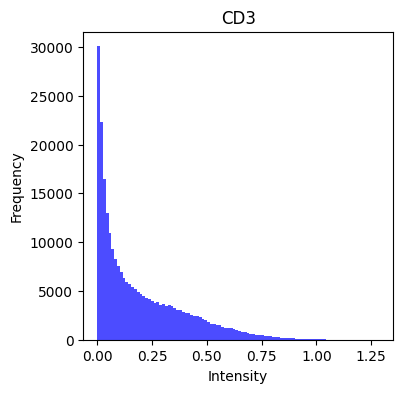

In [8]:
hp.pl.histogram(
    sdata,
    img_layer="raw_image_fov0_processed",
    channel="CD3",
    bins=100,
    fig_kwargs={
        "figsize": (4, 4),
    },
)

## 3. Pixel clustering

In [9]:
import flowsom as fs
from dask.distributed import Client, LocalCluster

work_with_client = False

if work_with_client:
    # client example
    cluster = LocalCluster(
        n_workers=1,
        threads_per_worker=10,
    )

    client = Client(cluster)
else:
    client = None

batch_model = fs.models.BatchFlowSOMEstimator

sdata, fsom, mapping = hp.im.flowsom(
    sdata,
    img_layer=["raw_image_fov0_processed", "raw_image_fov1_processed"],
    output_layer_clusters=[
        "raw_image_fov0_flowsom_clusters",
        "raw_image_fov1_flowsom_clusters",
    ],  # we need output_cluster_layer and output_meta_cluster_layer --> these will both be labels layers
    output_layer_metaclusters=[
        "raw_image_fov0_flowsom_metaclusters",
        "raw_image_fov1_flowsom_metaclusters",
    ],
    n_clusters=20,
    random_state=111,
    chunks=512,
    client=client,
    model=batch_model,
    num_batches=10,
    xdim=10,
    ydim=10,
    z_score=True,
    z_cap=3,
    persist_intermediate=True,
    overwrite=True,
)

2025-09-10 09:13:23,673 - harpy.image.pixel_clustering._clustering - INFO - Extracting random sample for FlowSOM training.
2025-09-10 09:13:23,677 - harpy.image.pixel_clustering._clustering - INFO - Start sampling
2025-09-10 09:13:23,722 - harpy.image.pixel_clustering._clustering - INFO - Start sampling
2025-09-10 09:13:23,876 - harpy.image.pixel_clustering._clustering - INFO - Start FlowSOM training.
2025-09-10 09:13:23.881 | DEBUG    | flowsom.main:__init__:82 - Reading input.
2025-09-10 09:13:23.882 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.
2025-09-10 09:13:27.095 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.
2025-09-10 09:13:27,334 - harpy.image.pixel_clustering._clustering - INFO - Finished FlowSOM training. Starting inference 
2025-09-10 09:13:27,579 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov0_flowsom_clusters'
2025-09-10 09:13:27,582 - harpy.image._manager - INFO - Writing results to laye

In [10]:
sdata = hp.tb.cluster_intensity(
    sdata,
    mapping=mapping,
    img_layer=["raw_image_fov0_processed", "raw_image_fov1_processed"],
    labels_layer=["raw_image_fov0_flowsom_clusters", "raw_image_fov1_flowsom_clusters"],
    to_coordinate_system=["fov0", "fov1"],
    output_layer="counts_clusters",
    overwrite=True,
)

2025-09-10 09:13:27,866 - harpy.table.pixel_clustering._cluster_intensity - INFO - Start allocation of intensities of image layer with name 'raw_image_fov0_processed' by labels in labels layer with name 'raw_image_fov0_flowsom_clusters'.
/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:286: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm[_SPATIAL] = coordinates
2025-09-10 09:13:28,337 - harpy.table.pixel_clustering._cluster_intensity - INFO - End allocation of image layer with name 'raw_image_fov0_processed' and labels layer with name 'raw_image_fov0_flowsom_clusters'.
2025-09-10 09:13:28,342 - harpy.table.pixel_clustering._cluster_intensity - INFO - Start allocation of intensities of image layer with name 'raw_image_fov1_processed' by labels in labels layer with name 'raw_image_fov1_flowsom_clusters'.
/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:286: ImplicitModificationWarning: Sett

## 4. Visualization of pixel clusters and metaclusters

INFO     Dropping coordinate system 'fov2' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov10' since it doesn't have relevant elements.                               
INFO     Dropping coordinate system 'fov6' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov8' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov3' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov9' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov1' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov7' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov5' since it doesn't have relevan

<Axes: title={'center': 'fov0'}>

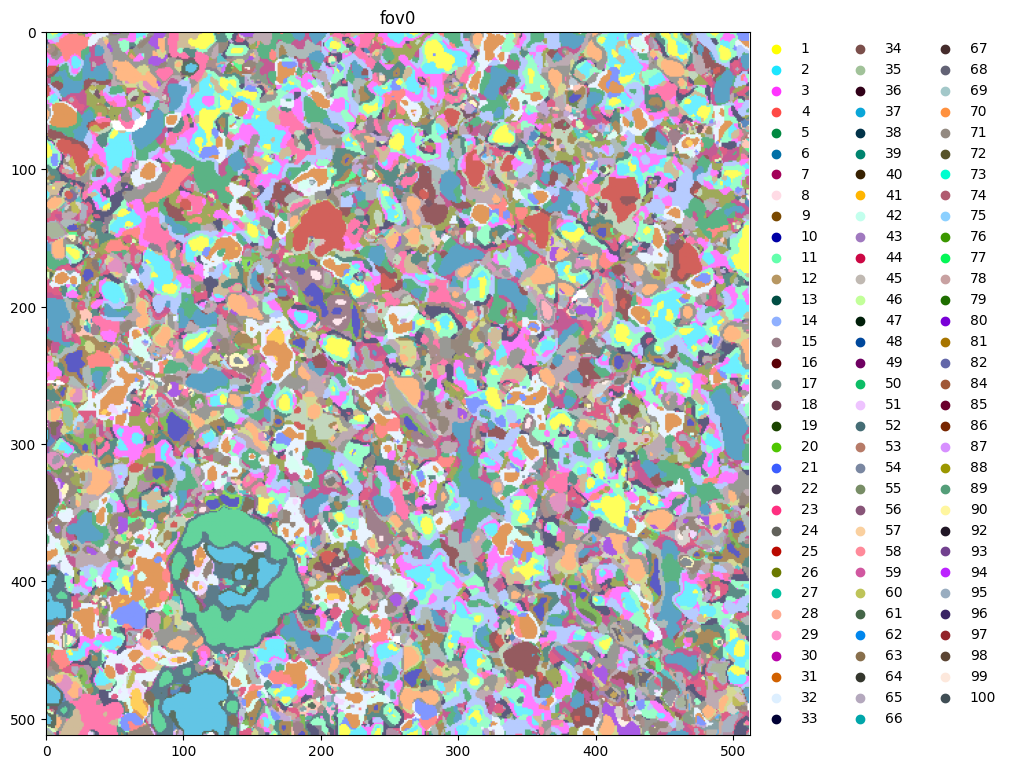

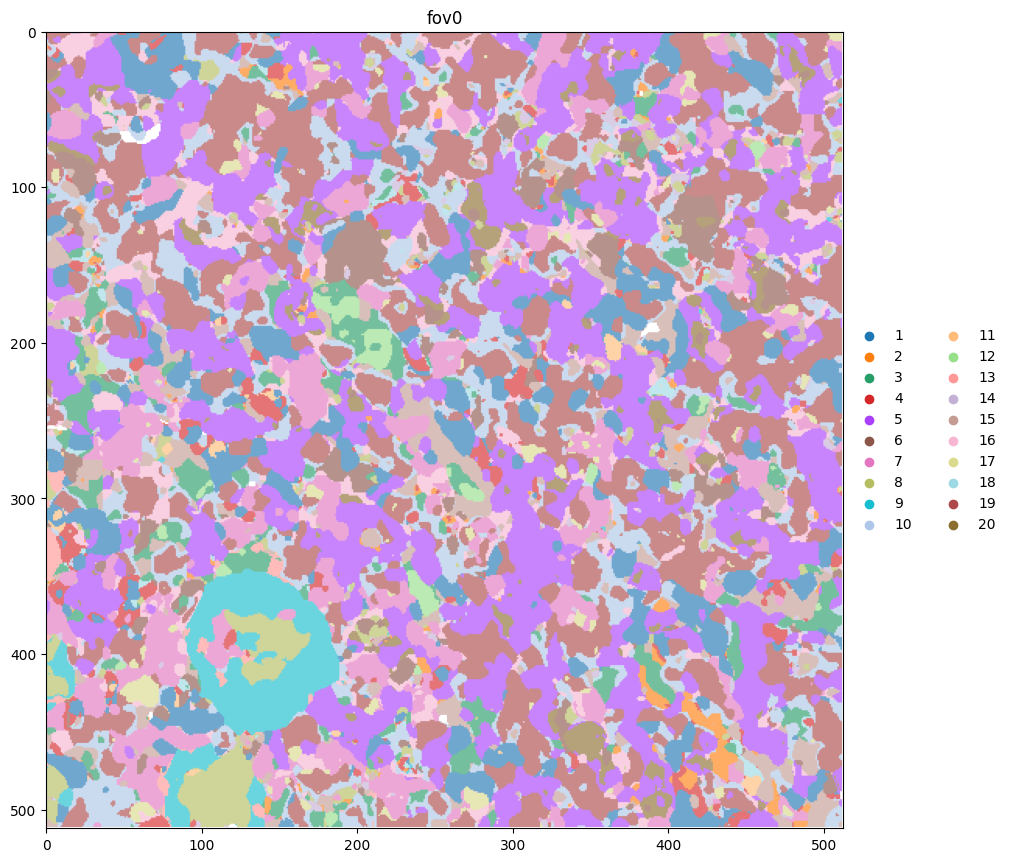

In [11]:
hp.pl.pixel_clusters(
    sdata,
    labels_layer="raw_image_fov0_flowsom_clusters",
    figsize=(10, 10),
    to_coordinate_system="fov0",
    render_labels_kwargs={"alpha": 1},
)

hp.pl.pixel_clusters(
    sdata,
    labels_layer="raw_image_fov0_flowsom_metaclusters",
    figsize=(10, 10),
    to_coordinate_system="fov0",
    render_labels_kwargs={"alpha": 1},
)

## 5. Heatmap of channel intensity per cluster and metacluster

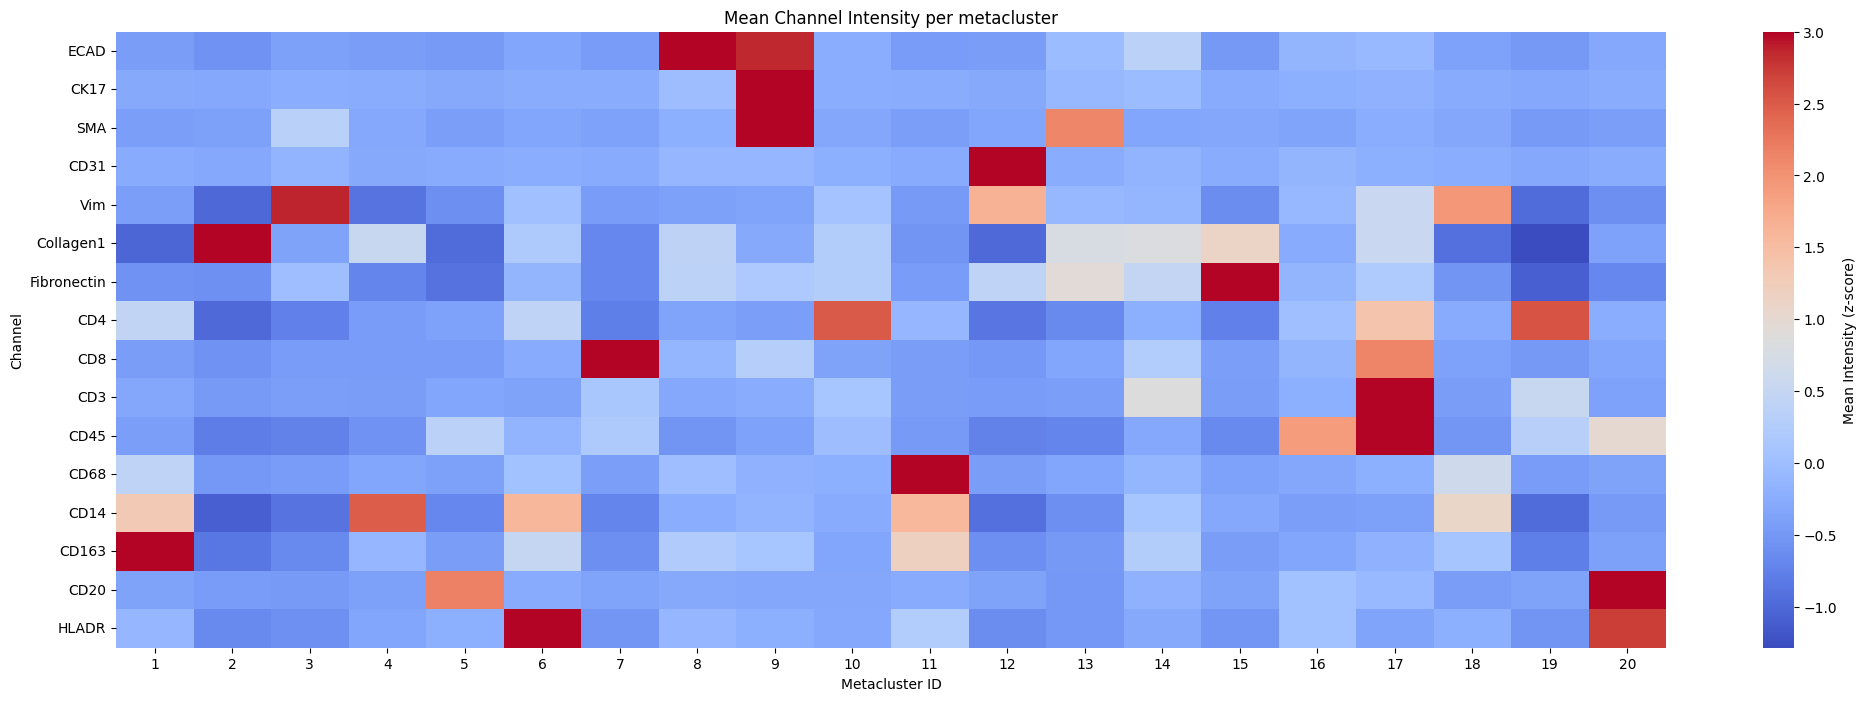

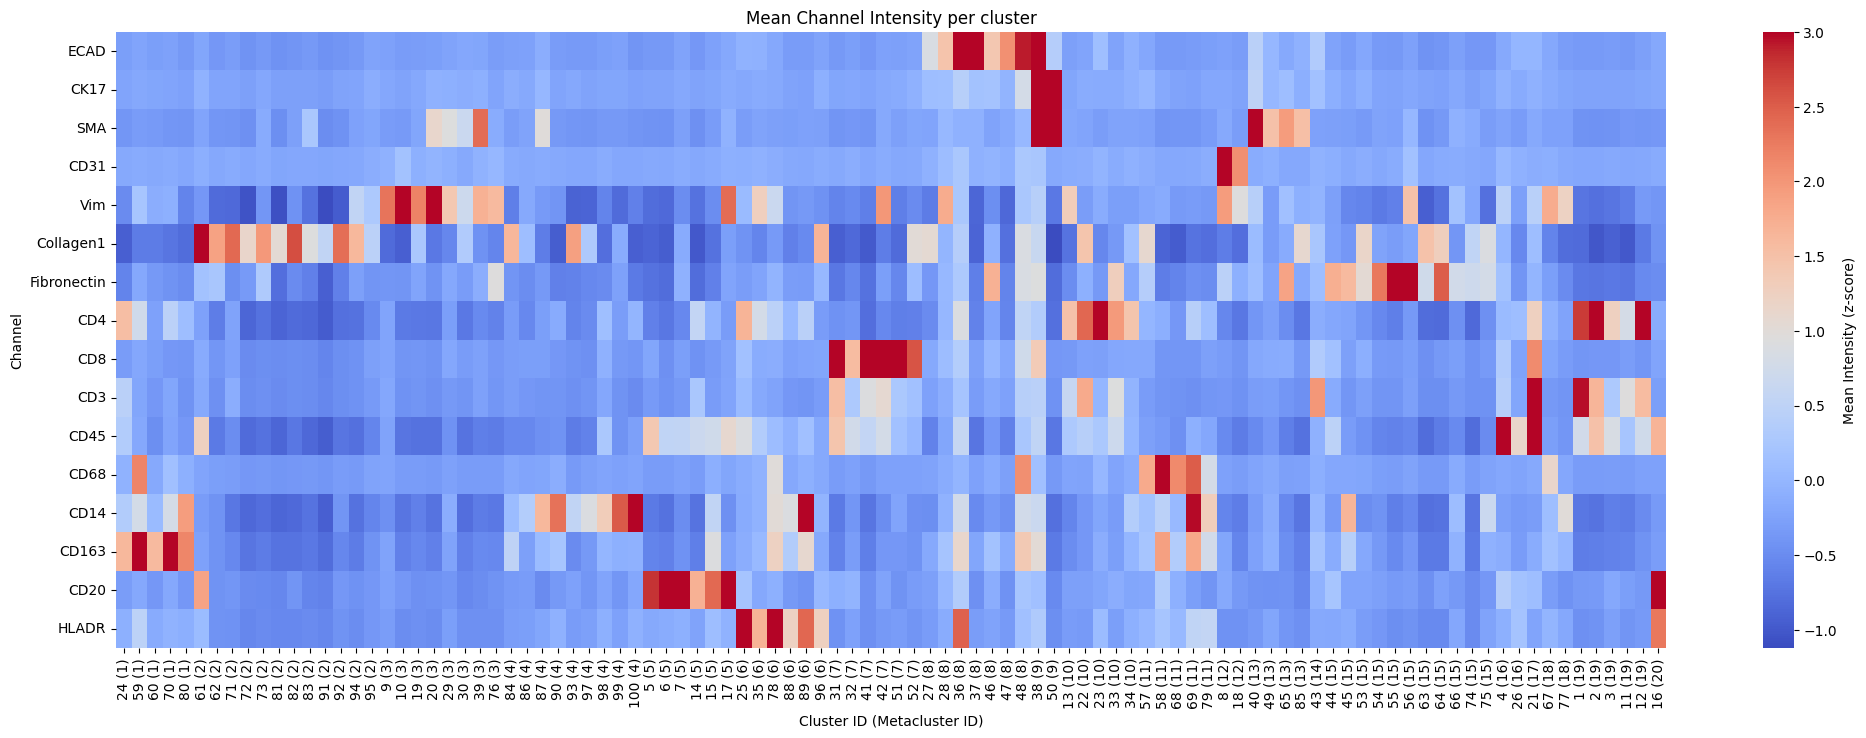

In [12]:
for _metaclusters in [True, False]:
    hp.pl.pixel_clusters_heatmap(
        sdata,
        table_layer="counts_clusters",
        figsize=(25, 8),
        fig_kwargs={"dpi": 100},
        linewidths=0.001,
        metaclusters=_metaclusters,
        z_score=True,
    )

## 6. Spatial pixel neighbors

2025-09-10 09:13:53,376 - harpy.image._manager - INFO - Writing results to layer 'labels_grid_f13ce23e-ffd2-4eeb-a806-de9e699d3331'
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1550: RuntimeWarning: invalid value encountered in divide
  results = [sum_labels(input * grids[dir].astype(float), labels, index) / normalizer
2025-09-10 09:13:53,450 - harpy.table.pixel_clustering._neighbors - INFO - Removing layer 'labels_grid_f13ce23e-ffd2-4eeb-a806-de9e699d3331' containing the spatial grid.
2025-09-10 09:13:53,450 - harpy.table.pixel_clustering._neighbors - INFO - Removing layer 'shapes_grid_f13ce23e-ffd2-4eeb-a806-de9e699d3331' containing the spatial grid.
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-10 09:13:53,452 - harpy.table.pixel_clustering._neighbors - INFO - Using '224' observations

  0%|          | 0/1000 [00:00<?, ?/s]

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return modu

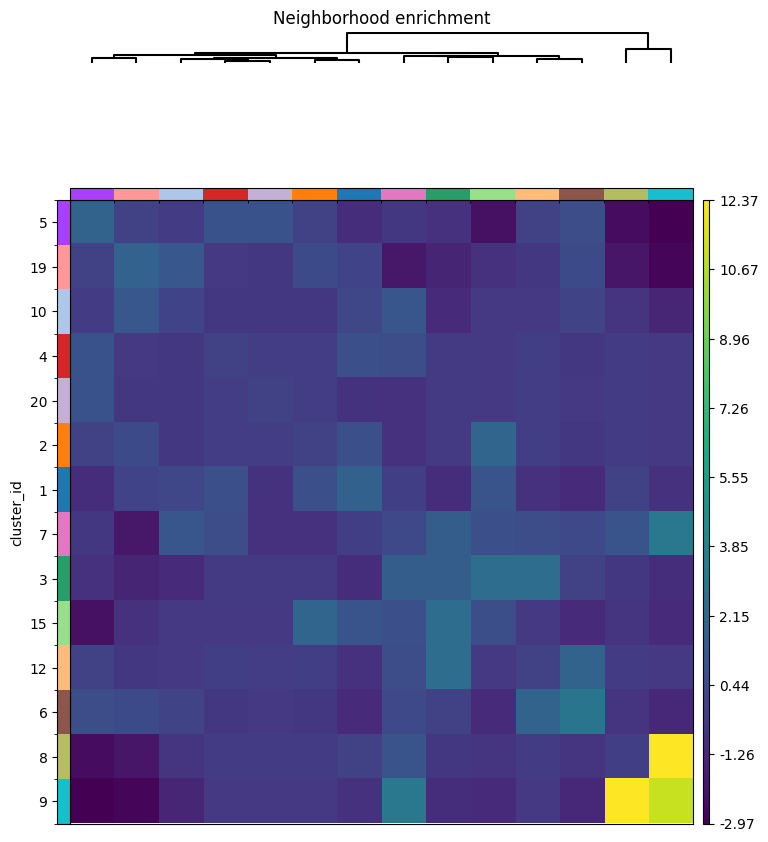

In [13]:
import numpy as np
import squidpy as sq

key_added = "cluster_id"

adata = hp.tb.spatial_pixel_neighbors(
    sdata,
    labels_layer="raw_image_fov0_flowsom_metaclusters",
    key_added=key_added,
    mode="most_frequent",
    grid_type="hexagon",
    size=20,
    subset=None,
)

adata.uns[f"{key_added}_nhood_enrichment"]["zscore"] = np.nan_to_num(
    adata.uns[f"{key_added}_nhood_enrichment"]["zscore"]
)
sq.pl.nhood_enrichment(adata, cluster_key=key_added, method="ward", mode="zscore", figsize=(8, 8))

## 7. Cell clustering

In [14]:
batch_model = fs.models.BatchFlowSOMEstimator

sdata, fsom = hp.tb.flowsom(
    sdata,
    labels_layer_cells=["label_whole_fov0", "label_whole_fov1"],
    labels_layer_clusters=[
        "raw_image_fov0_flowsom_metaclusters",
        "raw_image_fov1_flowsom_metaclusters",
    ],  # here you could also choose "ark_pixel_som_cluster"
    output_layer="table_cell_clustering_flowsom",
    chunks=512,
    model=batch_model,
    num_batches=10,
    random_state=100,
    overwrite=True,
)

2025-09-10 09:14:04,071 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'label_whole_fov0'
2025-09-10 09:14:04,090 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'label_whole_fov1'
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/models/models.py:1144: UserWarning: Converting `region_key: fov_labels` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table_cell_clustering_flowsom` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
2025-09-10 09:14:04.142 | DEBUG    | flowsom.main:__init__:82 - Reading input.


INFO     Dropping coordinate system 'fov2' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov10' since it doesn't have relevant elements.                               
INFO     Dropping coordinate system 'fov6' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov8' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov3' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov9' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov1' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov7' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov5' since it doesn't have relevan

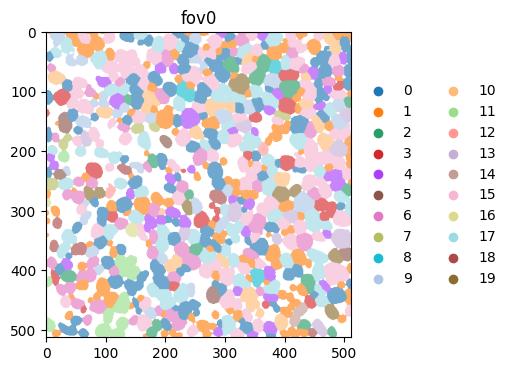

In [15]:
sdata.pl.render_labels("label_whole_fov0", table_name="table_cell_clustering_flowsom", color="metaclustering").pl.show(
    figsize=(5, 5)
)

In [16]:
# "table_cell_clustering_flowsom" is annotated by segmentation masks, so they can also be visualised using napari-spatialdata
sdata["table_cell_clustering_flowsom"].uns["spatialdata_attrs"]

# from napari_spatialdata import Interactive

# Interactive(sdata)

{'region': ['label_whole_fov0', 'label_whole_fov1'],
 'region_key': 'fov_labels',
 'instance_key': 'cell_ID'}

## Optional export to a .csv format that can be used for visualization using the ark analysis [gui](https://github.com/angelolab/ark-analysis/blob/main/templates/2_Pixie_Cluster_Pixels.ipynb)

In [17]:
# weighted channel average for visualization -> calculate this on the flowsom clustered matrix
sdata = hp.tb.weighted_channel_expression(
    sdata,
    table_layer_cell_clustering="table_cell_clustering_flowsom",
    table_layer_pixel_cluster_intensity="counts_clusters",
    output_layer="table_cell_clustering_flowsom",
    clustering_key=ClusteringKey._METACLUSTERING_KEY,
    overwrite=True,
)

2025-09-10 09:14:13,947 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding mean over obtained cell clusters '(clustering)' of the average marker expression for each cell weighted by pixel cluster count to '.uns[ 'clustering_channels' ]' of table layer 'table_cell_clustering_flowsom'
2025-09-10 09:14:13,949 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding mean over obtained cell clusters '(metaclustering)' of the average marker expression for each cell weighted by pixel cluster count to '.uns[ 'metaclustering_channels' ]' of table layer 'table_cell_clustering_flowsom'
2025-09-10 09:14:13,949 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding average marker expression for each cell weighted by pixel cluster count to '.obs' of table layer 'table_cell_clustering_flowsom'
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table_cell_clustering_

In [18]:
from harpy.table.cell_clustering._utils import _export_to_ark_format as _export_to_ark_format_cells
from harpy.table.pixel_clustering._cluster_intensity import _export_to_ark_format as _export_to_ark_format_pixels

df = _export_to_ark_format_pixels(adata=sdata["counts_clusters"], output=None)
(
    df_cell_som_cluster_count_avg,
    df_cell_som_cluster_channel_avg,
    df_cell_meta_cluster_channel_avg,
) = _export_to_ark_format_cells(sdata, table_layer="table_cell_clustering_flowsom", output=None)
df.head()

2025-09-10 09:14:17,239 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.
2025-09-10 09:14:17,240 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.
2025-09-10 09:14:17,242 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.


channels,CD3,CD4,CD8,CD14,CD20,CD31,CD45,CD68,CD163,CK17,Collagen1,Fibronectin,ECAD,HLADR,SMA,Vim,pixel_meta_cluster,pixel_som_cluster,count
cells,,,,,,,,,,,,,,,,,,,
1_counts_clusters_be65767f,0.014224,0.011135,0.000439,0.000770,0.000571,0.000093,0.006685,0.000355,0.000489,0.000289,0.001440,0.000838,0.000365,0.000427,0.000255,0.001119,19,1,11036
2_counts_clusters_be65767f,0.008938,0.011940,0.000478,0.000682,0.000632,0.000104,0.009583,0.000360,0.000508,0.000284,0.000927,0.000799,0.000360,0.000511,0.000176,0.000979,19,2,11467
3_counts_clusters_be65767f,0.003430,0.006675,0.000475,0.001037,0.000970,0.000197,0.007054,0.000413,0.000618,0.000306,0.001216,0.000903,0.000459,0.001101,0.000275,0.001146,19,3,15124
4_counts_clusters_be65767f,0.003878,0.003102,0.002092,0.002219,0.002277,0.000944,0.027310,0.000966,0.001862,0.001035,0.003627,0.003540,0.001010,0.001819,0.000921,0.004511,16,4,6108
5_counts_clusters_be65767f,0.000922,0.001126,0.000853,0.000871,0.007788,0.000179,0.009212,0.000358,0.000651,0.000301,0.001303,0.000683,0.000336,0.001534,0.000260,0.000930,5,5,13677


In [19]:
df_cell_meta_cluster_channel_avg.head()

channels,cell_meta_cluster,CD3,CD4,CD8,CD14,CD20,CD31,CD45,CD68,CD163,CK17,Collagen1,Fibronectin,ECAD,HLADR,SMA,Vim,cell_meta_cluster_rename
0,1,0.003693,0.004935,0.001193,0.002168,0.003223,0.000390,0.006117,0.000925,0.001739,0.002062,0.002388,0.002011,0.001283,0.001864,0.001554,0.002601,1
1,2,0.003210,0.003988,0.001191,0.002582,0.001073,0.000576,0.004041,0.001288,0.002118,0.000640,0.002468,0.001839,0.000816,0.001967,0.000891,0.002520,2
2,3,0.002508,0.002269,0.001324,0.002539,0.001000,0.000835,0.003071,0.001421,0.001742,0.000643,0.002511,0.002192,0.001324,0.001380,0.000964,0.002767,3
3,4,0.002131,0.002575,0.001358,0.002726,0.001320,0.000761,0.003710,0.001321,0.001748,0.000817,0.003287,0.003577,0.000875,0.001700,0.001105,0.002688,4
4,5,0.002457,0.003191,0.001047,0.001770,0.005857,0.000353,0.006862,0.000716,0.001501,0.000435,0.002031,0.001510,0.000587,0.001752,0.000543,0.002258,5
